In [1]:
import pandas as pd
import numpy as np

def read_filt(fname):
    import pickle
    from pymatgen.core import Structure
    from pymatgen.analysis import cost
    from pymatgen.analysis import hhi
    from pymatgen.core import Composition
    cost_db = cost.CostDBElements()
    analyzer = cost.CostAnalyzer(cost_db)
    with open(fname, "rb") as f:
        data = pickle.load(f)
    formulae = []
    costs = []
    for id, s in data["structure"].items():
        f = Structure.from_dict(s).formula
        formulae.append(f)
        try:
            costs.append(analyzer.get_cost_per_mol(Composition(f)))
        except:
            costs.append(None)
    data["formula"] = formulae
    data["fom"] = data["bandgap"] * data["refractive_index"]
    data["cost_by_elements"] = costs
    return data

def eps_static(matrix):
    """Fix the epsilon static matrix from MongoDB"""
    arr = np.array([[0, 0, 0], [0, 0, 0], [0, 0, 0]], dtype=np.float64)
    for ind, row in enumerate(matrix):
        for jnd, col in enumerate(row):
            arr[ind][jnd] = float(row[jnd]) if isinstance(row[jnd], float) else 0.0

    return arr

# Load iterations of our AL loop

In [2]:
data = []
for v in range(1, 7):
    data.append(read_filt(f"df_outputs_filtout_v{v}.pkl"))

/home/mevans/repos/re2fractive/re2fractive/experiments/9_exploring_candidates/.venv/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:120: UserWarning: No Pauling electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/mevans/repos/re2fractive/re2fractive/experiments/9_exploring_candidates/.venv/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:120: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/mevans/repos/re2fractive/re2fractive/experiments/9_exploring_candidates/.venv/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:120: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warning

## Load Riebesel data from arXiv:[2401.05848](https://arxiv.org/abs/2401.05848)

In [46]:
from pymongo import MongoClient
from pathlib import Path
from pymatgen.core import Structure
import numpy as np

query = False
if not Path("riebesel_db.csv").exists() or query:
    cluster = "atomate-cluster.q8s9p.mongodb.net/atomate"
    server = f"mongodb+srv://readonly:kHsBcWwTb4@{cluster}"
    db = MongoClient(server).dielectrics
    close_to_hull_high_fom = db.tasks.find({
      "e_above_hull_pbe": {"$lt": 0.05},
      "output.bandgap": { "$gt": 0.5 },
      "output.epsilon_static.0.0": { "$gt": 3 },
    })
    riebesell_structures = list(close_to_hull_high_fom)
    riebesel_df = pd.DataFrame.from_dict([d["output"] for d in riebesell_structures])
    refractive_indices = []
    formulae = []
    for row in riebesel_df.iterrows():
        eps = np.array(row[1]["epsilon_static"], dtype=np.float64)
        refractive_indices.append(np.sqrt(eps[0][0]))
        f = Structure.from_dict(row[1]["structure"]).formula
        formulae.append(f)
    riebesel_df["formula"] = formulae
    riebesel_df["refractive_index"] = refractive_indices
    riebesel_df["fom_pbe" ] = riebesel_df["bandgap"] * riebesel_df["refractive_index"]
    riebesel_df.to_csv("riebesel_db.csv")
else:
    riebesel_df = pd.read_csv("riebesel_db.csv")

In [86]:
# Remove pathological structure
riebesel_df = riebesel_df[riebesel_df["refractive_index"] < 20]
riebesel_df = riebesel_df[riebesel_df["piezo_tensor"].notna()]

In [10]:
def get_riebesell_structures_from_export():
    import json
    
    with open("dielectrics.tasks.json", "r") as f:
        janosh = json.load(f)

    for ind, d in enumerate(janosh):
        try:
            janosh[ind]["output"]["refractive_index"] = np.sqrt(np.trace(eps_static(janosh[ind]["output"]["epsilon_static"])) // 3)
            janosh[ind]["output"]["dielectric_tensor"] = eps_static(janosh[ind]["output"]["epsilon_static"])
        except:
            janosh[ind]["output"]["refractive_index"] = None
    
    return pd.DataFrame.from_dict([d["output"] for d in janosh])

## Load final data of Carriço *et al* from [10.1103/PhysRevMaterials.8.015201](https://doi.org/10.1103/PhysRevMaterials.8.015201)

In [38]:
carrico_table = """
KTe2As 166 40.3 15.7 4.0 1.1 1.4 0.3 52 LiTiCoGe 216 15.7 22.2 4.7 1.2 1.6 0.4 0 Ca(AlAs)2 166 5.7 11.4 3.4 0.9 1.7 0.8 27 TiGePt 216 5.0 19.8 4.5 0.9 1.7 0.8 0 LiTaSiOs 216 15.7 20.8 4.6 0.5 1.7 1.2 0 LiBeAs 186 5.3 10.8 3.3 1.4 1.7 0.4 25 ZrHN 216 47.1 12.1 3.5 1.6 1.7 0.1 48 LiHfInPt 216 7.8 17.7 4.2 1.0 1.8 0.8 0 NdWN3 160 215.7 13.0 3.6 0.6 1.8 1.2 54 AsIrSe 29 4.4 17.4 4.2 1.2 1.8 0.6 0 HfSnPt 216 4.0 16.4 4.1 0.9 1.8 0.9 0 LiZrGeIr 216 11.4 17.8 4.2 1.5 2.0 0.5 0 BiSF 62 65.4 8.1 2.8 2.0 2.1 0.1 20 Ba2NbTlO6 225 62.7 5.7 2.4 2.1 2.2 0.1 6 CaMgTe2 166 10.0 7.5 2.7 1.6 2.3 0.6 48 HfHN 216 28.3 10.0 3.2 2.0 2.3 0.2 0 CaTe2Pb 166 20.7 10.5 3.2 2.2 2.3 0.1 22 LiHfSiIr 216 11.2 15.9 4.0 1.7 2.3 0.6 16 PIrS 29 3.1 14.4 3.8 1.7 2.4 0.7 0 Na4HfTe4 121 2.5 4.0 2.0 2.2 2.4 0.2 59 ZrZnN2 122 6.6 7.4 2.7 2.1 2.4 0.3 65 ScTaO4 14 73.0 5.3 2.3 2.6 2.6 0.0 21 NaTaO3 161 124.4 5.2 2.3 2.7 2.7 0.0 1 Na3TeH 221 8.6 4.8 2.2 2.6 2.8 0.2 0 LiAlC 216 5.6 7.4 2.7 0.8 3.3 2.5 26 TaBiO4 30 31.7 5.9 2.4 3.3 3.3 0.0 43 BeZnS2 33 2.9 5.6 2.4 3.4 3.4 0.0 16 KTaO3 227 63.9 4.4 2.1 3.3 3.5 0.3 23 Li3TeH 221 11.6 6.3 2.5 2.9 3.7 0.8 12 HfZrO4† 50 146.6 5.3 2.3 3.7 3.8 0.1 67 NaBO2 122 5.9 2.8 1.7 6.1 6.3 0.2 96 Be2P2O7 15 3.5 2.7 1.7 6.3 6.3 0.0 32
""".split()

carrico_df = pd.DataFrame()

structures = []
for ind, e in enumerate(carrico_table):
    if ind % 9 != 0:
        continue
    formula, spg, e0, einf, n, E_g, E_g_d, delta, E_hull = carrico_table[ind:ind+9]
    structures.append(
        {"formula": formula, "spg": int(spg), "e0": float(e0), "einf": float(einf), "refractive_index": float(n), "bandgap": float(E_g), "E_g_d": float(E_g_d), "delta": float(delta), "E_hull": float(E_hull)}
    )
carrico_df = pd.DataFrame.from_dict(structures)

## Define our Pareto-optimal structures

In [134]:
regions = np.arange(0.2, 8, 0.5)
best = {}
for ind, r in enumerate(regions):
    if ind + 1 == len(regions):
        break
    for d in data:
        top5 = d[d["bandgap"] <= regions[ind+1]][d["bandgap"] >= regions[ind]].sort_values("fom", ascending=False).head(1)
        if best.get(r) is not None:
            best[r] = pd.concat([best[r], top5])
        else:
            best[r] = top5

/tmp/ipykernel_30621/50845177.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top5 = d[d["bandgap"] <= regions[ind+1]][d["bandgap"] >= regions[ind]].sort_values("fom", ascending=False).head(1)
/tmp/ipykernel_30621/50845177.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top5 = d[d["bandgap"] <= regions[ind+1]][d["bandgap"] >= regions[ind]].sort_values("fom", ascending=False).head(1)
/tmp/ipykernel_30621/50845177.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top5 = d[d["bandgap"] <= regions[ind+1]][d["bandgap"] >= regions[ind]].sort_values("fom", ascending=False).head(1)
/tmp/ipykernel_30621/50845177.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top5 = d[d["bandgap"] <= regions[ind+1]][d["bandgap"] >= regions[ind]].sort_values("fom", ascending=False).head(1)
/tmp/ipykernel_30621/50845177.py:7: UserWarning: Boolean Series key will be reindexe

/tmp/ipykernel_30621/4280493268.py:31: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(gen["bandgap"], gen["refractive_index"], label=label, c=cmap[ind], **us_args)
/tmp/ipykernel_30621/4280493268.py:50: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(gen["bandgap"], gen["bandgap"] * gen["refractive_index"], label=label, c=cmap[ind], **us_args)
/tmp/ipykernel_30621/4280493268.py:60: UserWarning: *c* argumen

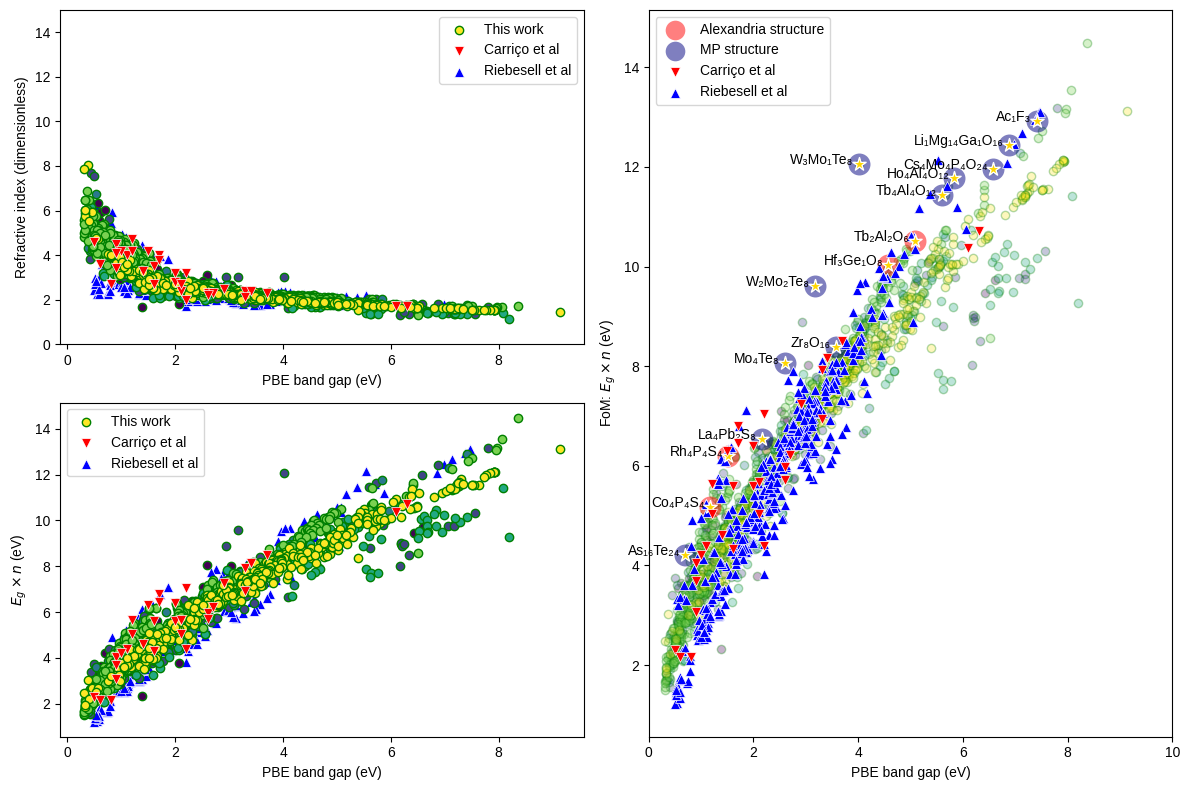

In [181]:
import matplotlib.pyplot as plt
import numpy as np
from pymatgen.core import Composition
import re
import matplotlib
matplotlib.rc('font',**{'family':'Liberation Sans'})


riebesel_args = {"alpha": 1, "c": "blue", "marker": "^", "s": 50, "lw": 0.5, "edgecolor": "white", "label": "Riebesell et al", "zorder": 0}
carrico_args = {"alpha": 1, "c": "red", "marker": "v", "s": 50, "lw": 0.5, "edgecolor": "white", "label": "Carriço et al", "zorder": 100}
us_args = {"edgecolor": "green", "lw": 1}


fig, axes = plt.subplots(2, 2, figsize=(12, 8))

gs = axes[0, 1].get_gridspec()
# remove the underlying axes
axes[0][1].remove()
axes[1][1].remove()
axbig = fig.add_subplot(gs[0:, -1])

ax = axes[0][0]
ax.set_xlabel("PBE band gap (eV)")
ax.set_ylabel("Refractive index (dimensionless)")
cmap = plt.colormaps.get_cmap("viridis")(np.linspace(0, 1, len(data)))
for ind, gen in enumerate(data):
    if ind == len(data) - 1:
        label = "This work"
    else:
        label = None
    ax.scatter(gen["bandgap"], gen["refractive_index"], label=label, c=cmap[ind], **us_args)
ax.scatter(carrico_df["bandgap"], carrico_df["refractive_index"], **carrico_args)
ax.scatter(riebesel_df["bandgap"], riebesel_df["refractive_index"], **riebesel_args)
ax.legend()
ax.set_ylim(0, 15)

#ax = axes[0][1]
#for ind, gen in enumerate(data):
#    ax.hist(gen["bandgap"], color=cmap[ind], bins=50, alpha=1, histtype="step", label=f"Gen {ind}")
#ax.legend()
#ax.set_xlabel("PBE band gap (eV)")
#ax.set_ylabel("Frequency")

ax = axes[1][0]
for ind, gen in enumerate(data):
    if ind == len(data) - 1:
        label = "This work"
    else:
        label = None
    ax.scatter(gen["bandgap"], gen["bandgap"] * gen["refractive_index"], label=label, c=cmap[ind], **us_args)
ax.scatter(carrico_df["bandgap"], carrico_df["bandgap"] * carrico_df["refractive_index"], **carrico_args)
ax.scatter(riebesel_df["bandgap"], riebesel_df["fom_pbe"], **riebesel_args)
ax.legend()
ax.set_xlabel("PBE band gap (eV)")
ax.set_ylabel("$E_g \\times n $ (eV)")


ax = axbig
for ind, gen in enumerate(data):
    ax.scatter(gen["bandgap"], gen["bandgap"] * gen["refractive_index"], c=cmap[ind], alpha=0.3, zorder=0, **us_args)
for r in best:
    r = next(best[r].sort_values("fom", ascending=False).head(1).iterrows())
    id = r[0]
    r = r[1]
    f = Composition(r["formula"]).iupac_formula.translate(str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")).replace(" ", "")
    if id.startswith("agm"):
        c = "red"
    else:
        c = "navy"
    ax.scatter(r["bandgap"], r["fom"], alpha=0.5, lw=0, c=c, s=250, zorder=0)
    ax.scatter(r["bandgap"], r["fom"], alpha=1, lw=1, c="gold", edgecolor="white", marker="*", s=100)#, label=f"{f} ({id})")
    ax.annotate(f, (r["bandgap"], r["fom"]), (r["bandgap"] - 0.1, r["fom"]), ha="right")

ax.set_xlim(0, 10)
ax.scatter(-1, r["fom"], alpha=0.5, lw=0, c="red", s=200, zorder=0, label="Alexandria structure")
ax.scatter(-1, r["fom"], alpha=0.5, lw=0, c="navy", s=200, zorder=0, label="MP structure")
ax.scatter(carrico_df["bandgap"], carrico_df["bandgap"] * carrico_df["refractive_index"], **carrico_args)
ax.scatter(riebesel_df["bandgap"], riebesel_df["bandgap"] * riebesel_df["refractive_index"], **riebesel_args)
ax.legend()
ax.set_xlabel("PBE band gap (eV)")
ax.set_ylabel("FoM: $E_g \\times n $ (eV)")
plt.tight_layout()
plt.savefig("carrico.png")
plt.savefig("carrico.pdf")

In [84]:
Riebesel_df.loc[riebesel_df["refractive_index"].idxmax()]

structure               {'@module': 'pymatgen.core.structure', '@class...
density                                                          6.034771
energy                                                          -9.434779
energy_per_atom                                                 -3.144926
forces                  [[0.00509683, -0.00882797, 0.0], [0.00509683, ...
stress                  [[-0.09328997, -0.0, -0.0], [0.0, -0.09328997,...
bandgap                                                            0.5474
cbm                                                                6.0068
vbm                                                                5.4594
is_gap_direct                                                       False
is_metal                                                            False
direct_gap                                                         0.6283
spacegroup              {'source': 'spglib', 'symbol': 'P3_121', 'numb...
epsilon_static          [[37.13663502,

In [255]:
best.shape

(30, 8)

In [121]:
df["fom"] = df["bandgap"] ** 2 * df["refractive_index"]

In [130]:
df.sort_values(by="fom", ascending=False).head(50)

,index,formula,bandgap,refractive_index,cost_elements,fom
12,mp-730101,H8,9.7197,1.155459,0.011289,109.159195
97,mp-1212843,Dy4 F12,7.7755,1.644137,758.168673,99.401916
96,mp-11347,Tb4 F12,7.7552,1.645946,1259.616361,98.992362
106,mp-561877,Ho4 F12,7.7482,1.644234,1224.812415,98.710961
134,mp-9371,Er4 F12,7.6163,1.643432,918.281274,95.332247
206,mp-1207204,Lu1 F3,7.4832,1.614003,1420.563911,90.381372
496,mp-721851,B24 H24 O48,7.0739,1.620868,2.563785,81.108320
23,mp-755574,Lu4 Al4 O12,5.7429,2.054393,5249.933566,67.755733
29,mp-756458,Er4 Al4 O12,5.8030,2.007800,485.959196,67.612269
210,mp-1213132,Er4 Mg4 B20 O40,6.1636,1.769403,487.708196,67.219557
